In [2]:
from sklearn import datasets, tree, metrics, ensemble
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import statistics
import einops

In [3]:
##### ustawienia
time_multiplicator = 1
seed = 244810
samples = 2410

In [4]:
def standarize(arr):
    for col in range(arr.shape[1]):
        xmean = np.mean( arr[:,col])
        xstd = np.std( arr[:,col])
        arr[:,col] = (arr[:,col] - xmean)/xstd
    return arr    
    
def normalize(arr):
    for col in range(arr.shape[1]):
        xmin = min( arr[:,col])
        xmax = max( arr[:,col])
        arr[:,col] = ((arr[:,col] - xmin )/(xmax-xmin) )* 2 -1
    
    return arr        

In [23]:
X, y  = datasets.make_classification(n_features=2, n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed, class_sep=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train = normalize(X_train)
# X_test = normalize(X_test)

In [48]:
def vis(model, name):
    fig, axs = plt.subplots(2, 2,figsize=(14,14))
    
    mycmap = "coolwarm"
    pred = model.predict(X_test)
    minv = np.min(X_train)+np.min(X_train)/10
    maxv = np.max(X_train)+np.max(X_train)/10
    mesh = np.meshgrid(np.arange(minv, maxv, 0.1), np.arange(minv, maxv, 0.1))[0]
    my_predict = np.array(model.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)


    my_predict = np.round(my_predict)
#     my_predict = np.where(my_predict > 1, 1, my_predict)
    axs[0,0].contourf(mesh, mesh.T, my_predict, alpha=0.2,cmap=mycmap)
    axs[0,0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker="o", alpha=0.5,cmap=mycmap)
    axs[0,0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker="+", alpha=0.2,cmap=mycmap)

    my_cm = metrics.confusion_matrix(y_test, np.round(pred))
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[0,1] ,cmap="plasma")
    # my_disp.im_.colorbar.remove()
    my_disp.ax_.set_ylabel('')


    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
    display.plot(ax=axs[1,0])
    
    axs[1,1].plot(model.progress)
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_ylabel('Accuracy')

    
    print(name)
    print(f'Czułość       |{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):9.4f}')
    print(f'Specyficzność |{my_cm[1][1]/(my_cm[0][1]+my_cm[1][1]):9.4f}')
    print(f'Skuteczność   |{metrics.accuracy_score(np.round(pred), y_test):9.4f}')
    print(f'BACC          |{(my_cm[1][1]/(my_cm[0][1]+my_cm[1][1])+my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))/2 :9.4f}')



In [7]:
class myNeuron():
    def __init__(self, size=2,batch=8, activationf='heavyside'):
        self.w = np.random.random(size+1)
        self.progress = []
        self.batch_size = batch
        
        if activationf == 'heavyside':
            self.activation = self.heavyside
            self.derivative = self.heavyside_der
            
        if activationf == 'logistic':
            self.activation = self.logistic
            self.derivative = self.logistic_der
        
        if activationf == 'sin':
            self.activation = self.sin
            self.derivative = self.sin_der
            
        if activationf == 'tanh':
            self.activation = self.tanh
            self.derivative = self.tanh_der
        
        if activationf == 'sign':
            self.activation = self.sign
            self.derivative = self.heavyside_der
        
        if activationf == 'relu':
            self.activation = self.relu
            self.derivative = self.heavyside

        if activationf == 'irelu':
            self.activation = self.irelu
            self.derivative = self.heavyside
        
    # dodać pozostałe pochodne
    
    def heavyside(self,X):
        return np.heaviside(X,0.5)
    def heavyside_der(self,X):
        return np.ones(X.shape[0])
    
    def logistic(self, X):
        return  1.0/(1+np.exp(-X))
    def logistic_der(self, X):
        return self.logistic(X) * (1-self.logistic(X))
    
    def sin(self, X):
        ans = np.sin(X)
        return  np.where(ans < 0, 0, ans)  
    def sin_der(self, X):
        ans = np.cos(X)
        return  np.where(ans < 0, 0, ans) 
    
    def tanh(self, X):
        ans = np.tanh(X)
        return  np.where(ans < 0, 0, ans) 
    def tanh_der(self, X):
        ans = 1 / np.cosh(X)**2
        return  np.where(ans < 0, 0, ans) 
    
    def sign(self, X):
        return  np.where(np.sign(X) < 0, 0, np.sign(X)) 

    def relu(self, X):
        ans = []
        for x in X:
            if x > 0:
                ans.append(x)
            else:
                ans.append(0)
        return  ans
    
    def irelu(self, X):
        ans = []
        for x in X:
            if x > 0:
                ans.append(x)
            else:
                ans.append(x*0.01)
        return  ans
    
    def add_dim(self, X):
        batch_size = X.shape[0]
        return np.c_[X, np.ones(batch_size)* -1.0]
    
    def fit(self, X, y, eta=0.01, epochs = 10):
        
        samples = X.shape[0]
        batch_divisible = samples - (samples % self.batch_size)
        indexes = np.arange(samples)
        for i in range(epochs):
            np.random.shuffle(indexes)
            X_batched = X[indexes][:batch_divisible]
            y_batched = y[indexes][:batch_divisible]
            
            X_batched = einops.rearrange(X_batched,"(batches size) features -> batches size features",size=self.batch_size)
            y_batched = einops.rearrange(y_batched,"(batches size) -> batches size",size=self.batch_size)

            for X_batch, y_true in zip(X_batched, y_batched):
                
                y_pred = self.predict(X_batch)
                b = y_true - y_pred
                grad = self.derivative(self.transform(X_batch))
                
                b = einops.rearrange(b,"size -> size 1")
                grad = einops.rearrange(grad, "size -> size 1")
                
                delta = eta * b * grad * self.add_dim(X_batch)
                self.w += np.mean(delta, axis=0)
                
            self.progress.append(metrics.accuracy_score(np.round(self.predict(X)), y))
                
    def predict(self, X):
        return self.activation(self.transform(X))
    
    def transform(self, X):
        X = self.add_dim(X)
        return X @ self.w
            
        

Funkcja logistyczna
Czułość       |   0.9878
Specyficzność |   0.9916
Skuteczność   |   0.9896
BACC          |   0.9897


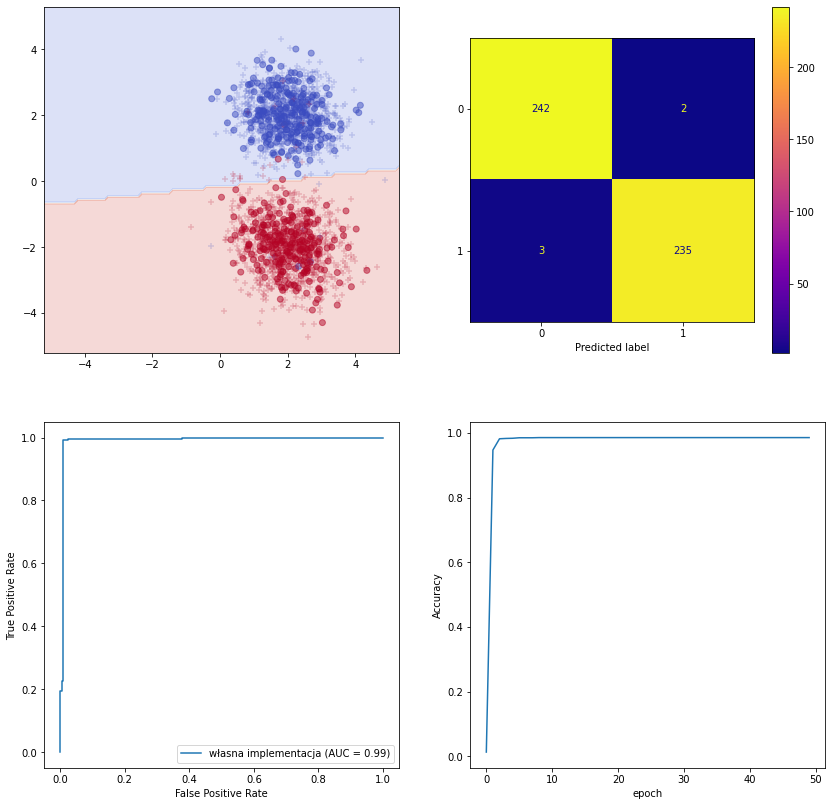

In [8]:
model = myNeuron(activationf='logistic')
model.fit(X_train,y_train,epochs = 50)
vis(model, "Funkcja logistyczna")

heavyside
Czułość       |   0.9958
Specyficzność |   0.9753
Skuteczność   |   0.9855
BACC          |   0.9856


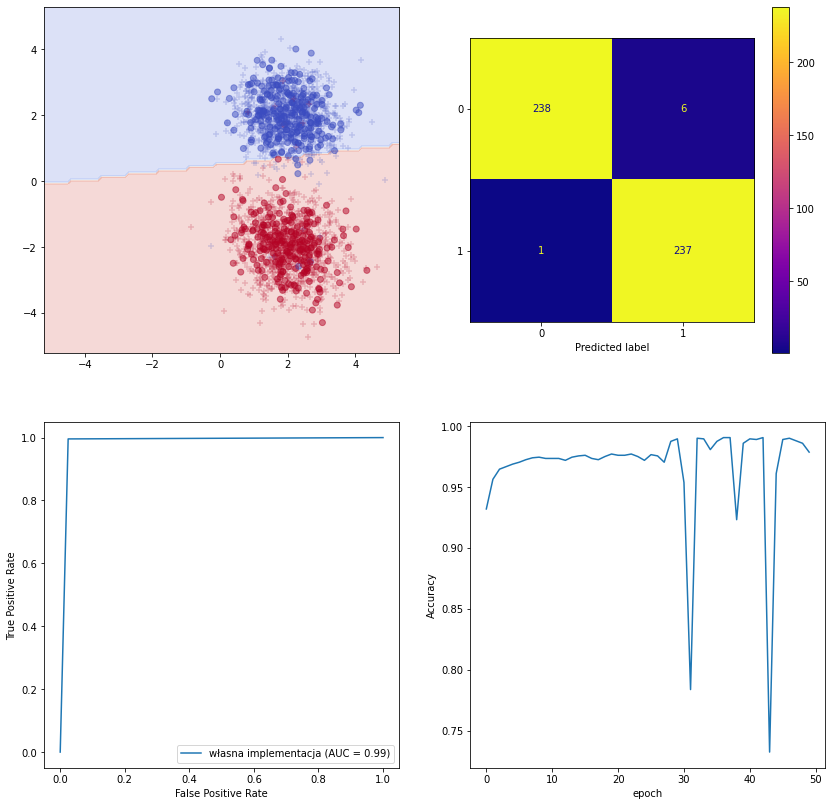

In [9]:
model = myNeuron(activationf='heavyside')
model.fit(X_train,y_train,epochs = 50)
vis(model, "heavyside")

sin
Czułość       |   0.8265
Specyficzność |   0.9947
Skuteczność   |   0.8921
BACC          |   0.9106


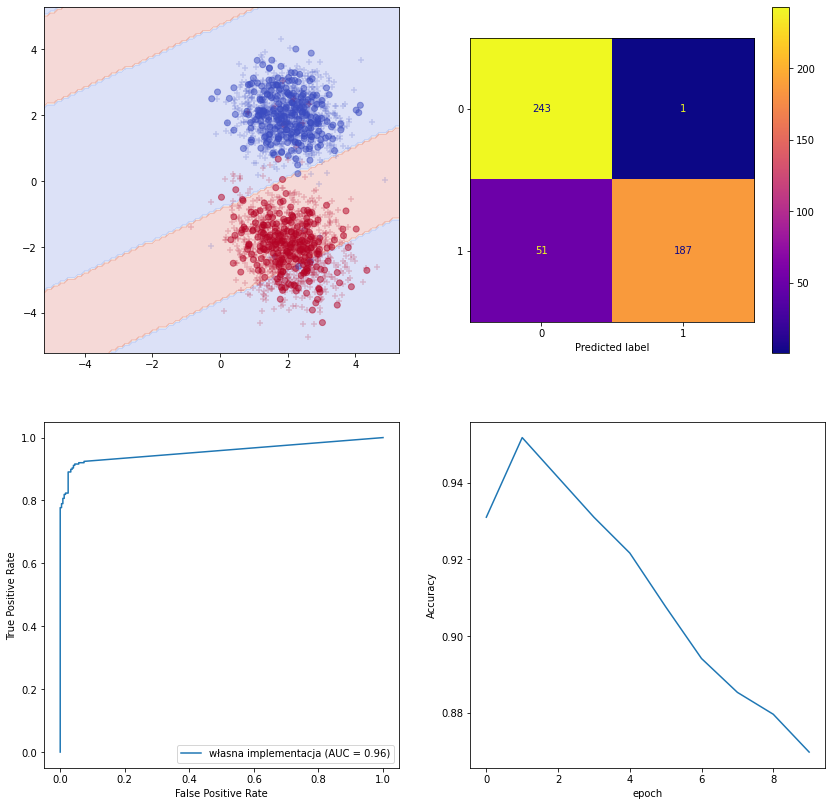

In [15]:
model = myNeuron(activationf='sin')
model.fit(X_train,y_train,epochs = 10)
vis(model, "sin")

tanh
Czułość       |   0.9918
Specyficzność |   0.9874
Skuteczność   |   0.9896
BACC          |   0.9896


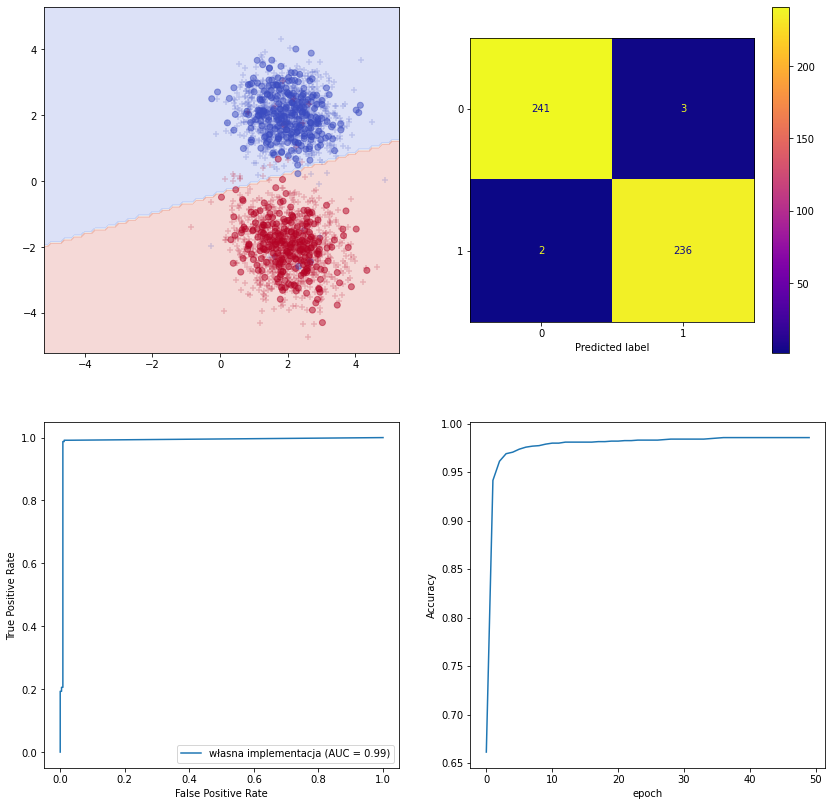

In [11]:
model = myNeuron(activationf='tanh')
model.fit(X_train,y_train,epochs = 50)
vis(model, "tanh")

sign
Czułość       |   0.9878
Specyficzność |   0.9916
Skuteczność   |   0.9896
BACC          |   0.9897


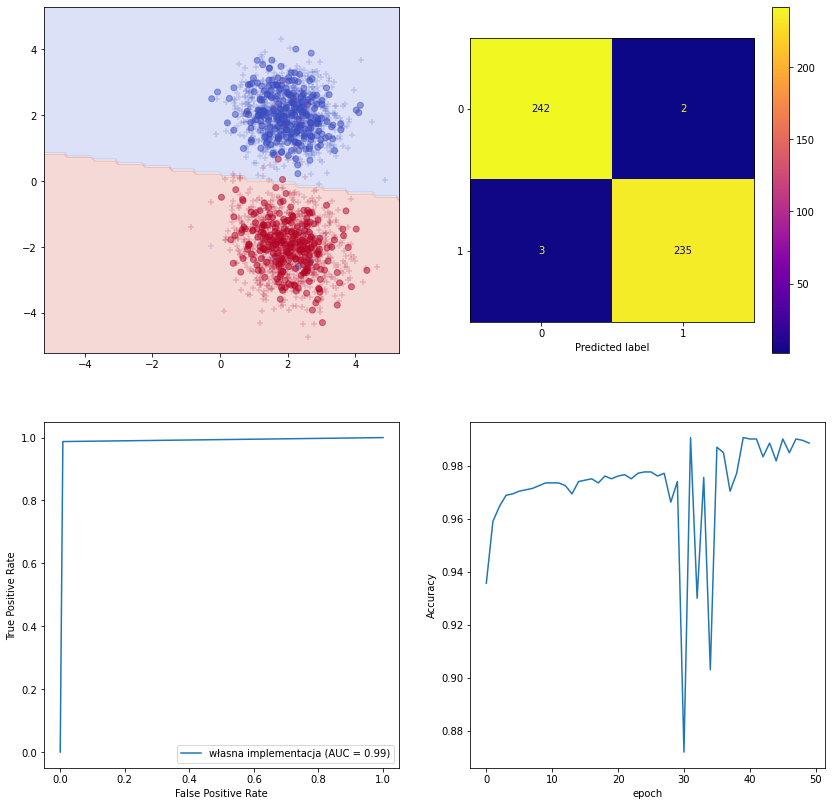

In [12]:
model = myNeuron(activationf='sign')
model.fit(X_train,y_train,epochs = 50)
vis(model, "sign")

relu
Czułość       |   0.9878
Specyficzność |   0.9916
Skuteczność   |   0.9896
BACC          |   0.9897


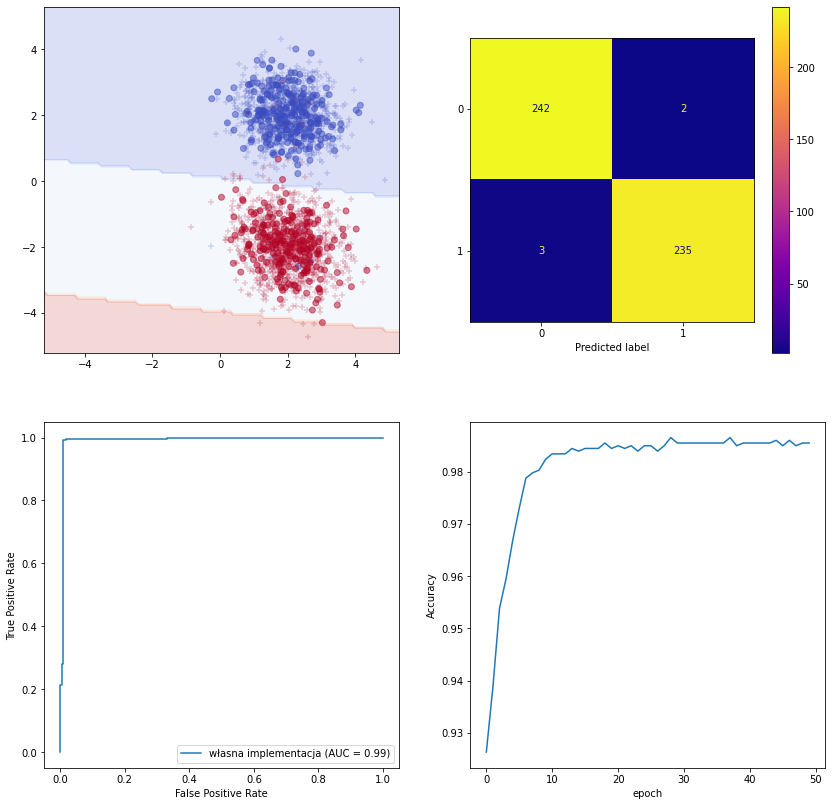

In [13]:
model = myNeuron(activationf='relu')
model.fit(X_train,y_train,epochs = 50)
vis(model, "relu")

irelu
Czułość       |   0.5062
Specyficzność |      nan
Skuteczność   |   0.5062
BACC          |      nan


C:\Users\rafal\AppData\Local\Temp\ipykernel_5252\1525881256.py:36: RuntimeWarning: invalid value encountered in longlong_scalars
  print(f'Specyficzność |{my_cm[1][1]/(my_cm[0][1]+my_cm[1][1]):9.4f}')
C:\Users\rafal\AppData\Local\Temp\ipykernel_5252\1525881256.py:38: RuntimeWarning: invalid value encountered in longlong_scalars
  print(f'BACC          |{(my_cm[1][1]/(my_cm[0][1]+my_cm[1][1])+my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))/2 :9.4f}')


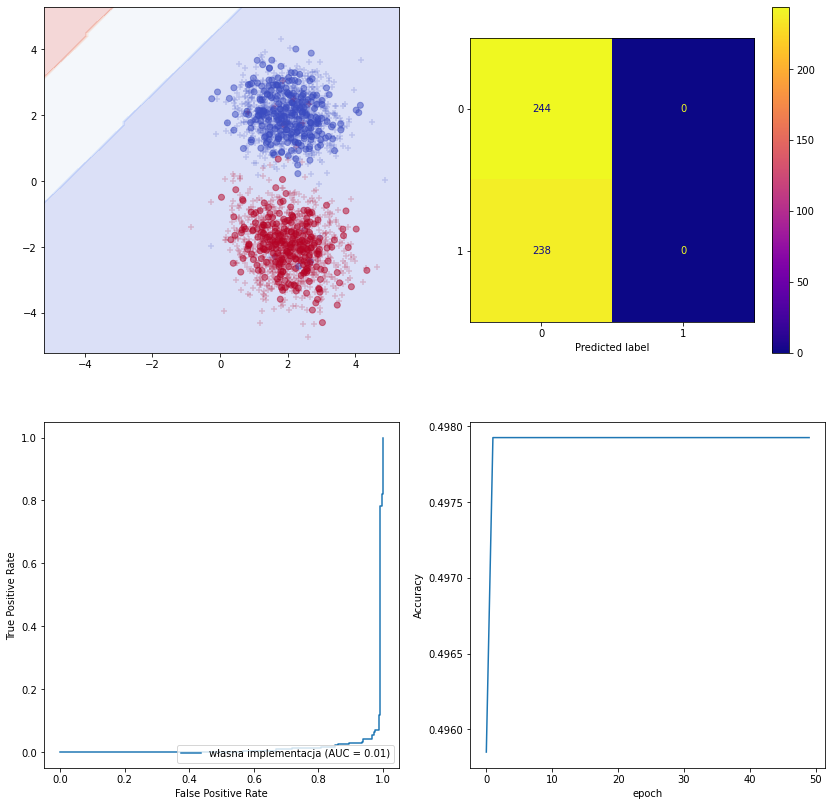

In [14]:
model = myNeuron(activationf='irelu')
model.fit(X_train,y_train,epochs = 50)
vis(model, "irelu")

### moons

In [33]:
moons, moons_c = datasets.make_moons(n_samples=samples, noise = 0.1, random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)
# y_train[y_train == 0] =-1
# y_test[y_test == 0] =-1
# M_train = normalize(M_train)
# M_test = normalize(M_test)


Funkcja logistyczna
Czułość       |   0.8360
Specyficzność |   0.8664
Skuteczność   |   0.8506
BACC          |   0.8512


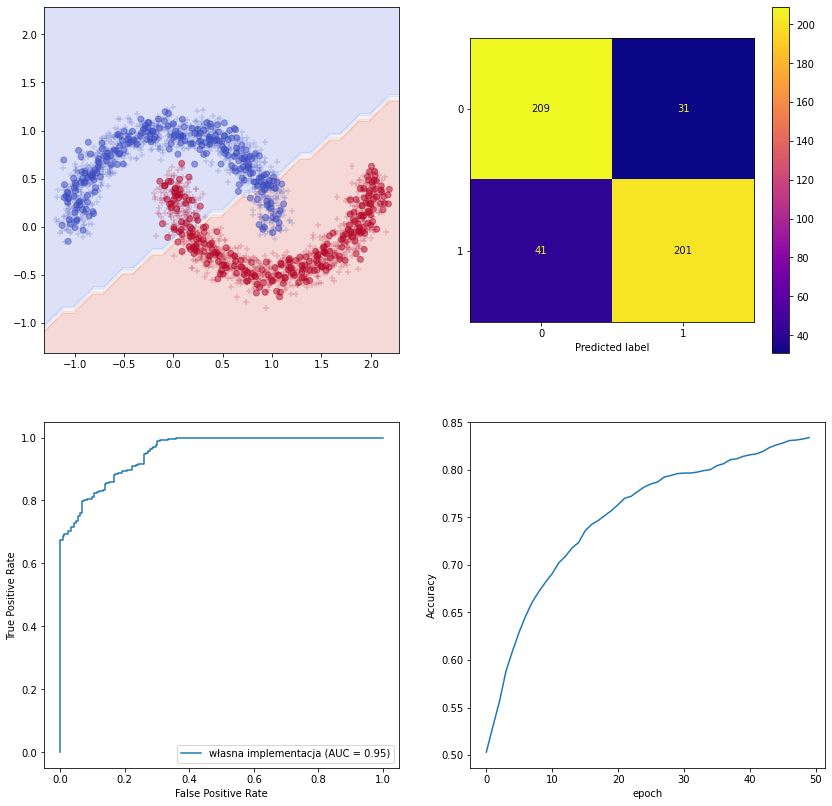

In [34]:
model = myNeuron(activationf='logistic')
model.fit(X_train,y_train,epochs = 50)
vis(model, "Funkcja logistyczna")

heavyside
Czułość       |   0.8577
Specyficzność |   0.9234
Skuteczność   |   0.8880
BACC          |   0.8906


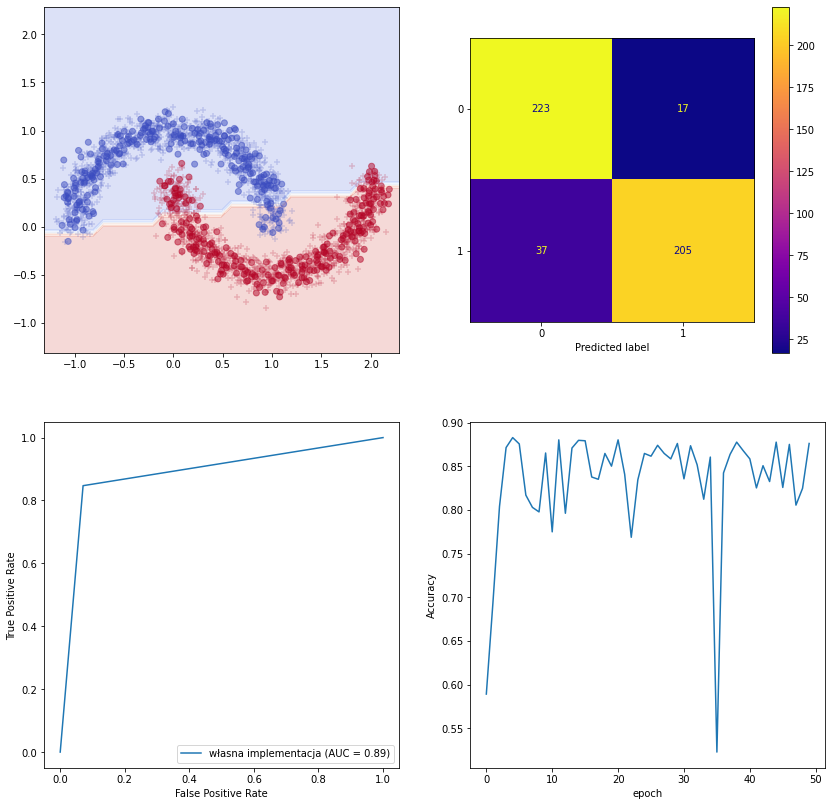

In [35]:
model = myNeuron(activationf='heavyside')
model.fit(X_train,y_train,epochs = 50)
vis(model, "heavyside")

sin
Czułość       |   0.8880
Specyficzność |   0.8921
Skuteczność   |   0.8900
BACC          |   0.8900


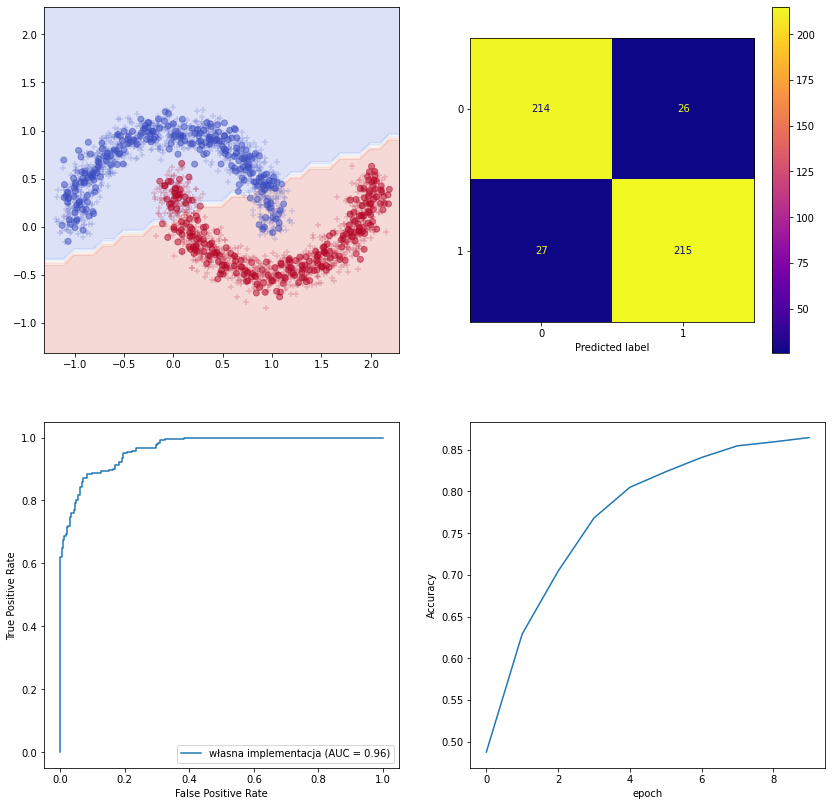

In [36]:
model = myNeuron(activationf='sin')
model.fit(X_train,y_train,epochs = 10)
vis(model, "sin")

tanh
Czułość       |   0.8958
Specyficzność |   0.8967
Skuteczność   |   0.8963
BACC          |   0.8963


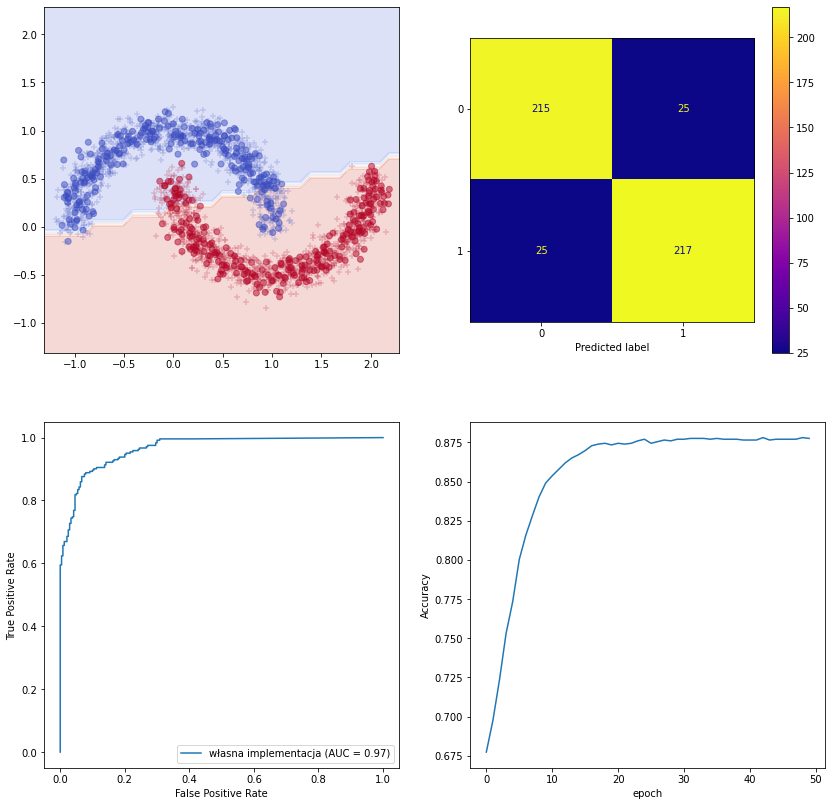

In [37]:
model = myNeuron(activationf='tanh')
model.fit(X_train,y_train,epochs = 50)
vis(model, "tanh")

sign
Czułość       |   0.7331
Specyficzność |   0.8308
Skuteczność   |   0.7739
BACC          |   0.7820


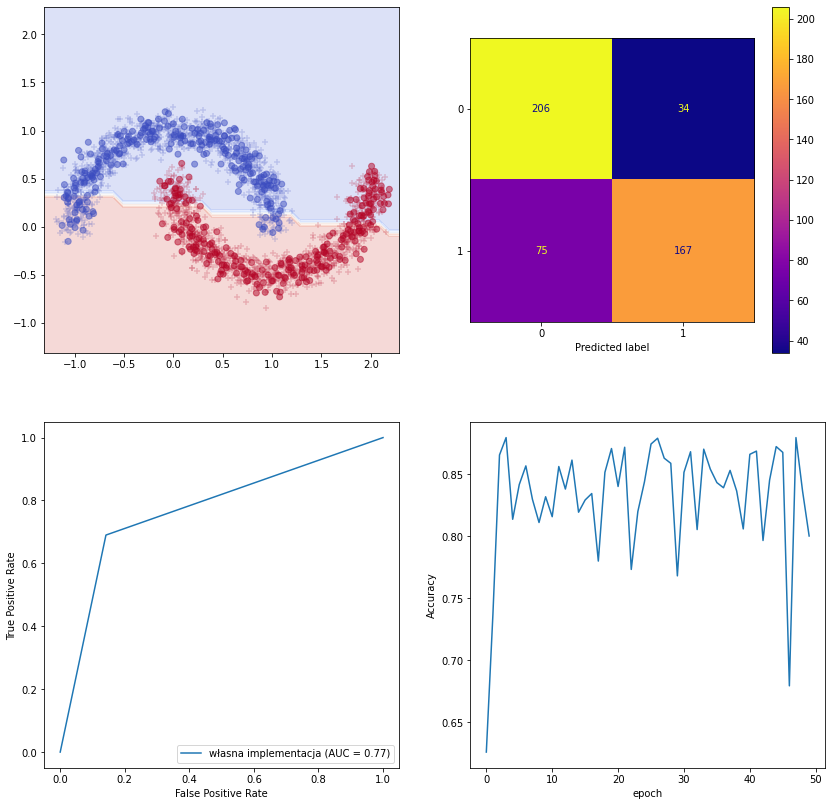

In [38]:
model = myNeuron(activationf='sign')
model.fit(X_train,y_train,epochs = 50)
vis(model, "sign")

relu
Czułość       |   0.8814
Specyficzność |   0.9258
Skuteczność   |   0.9025
BACC          |   0.9036


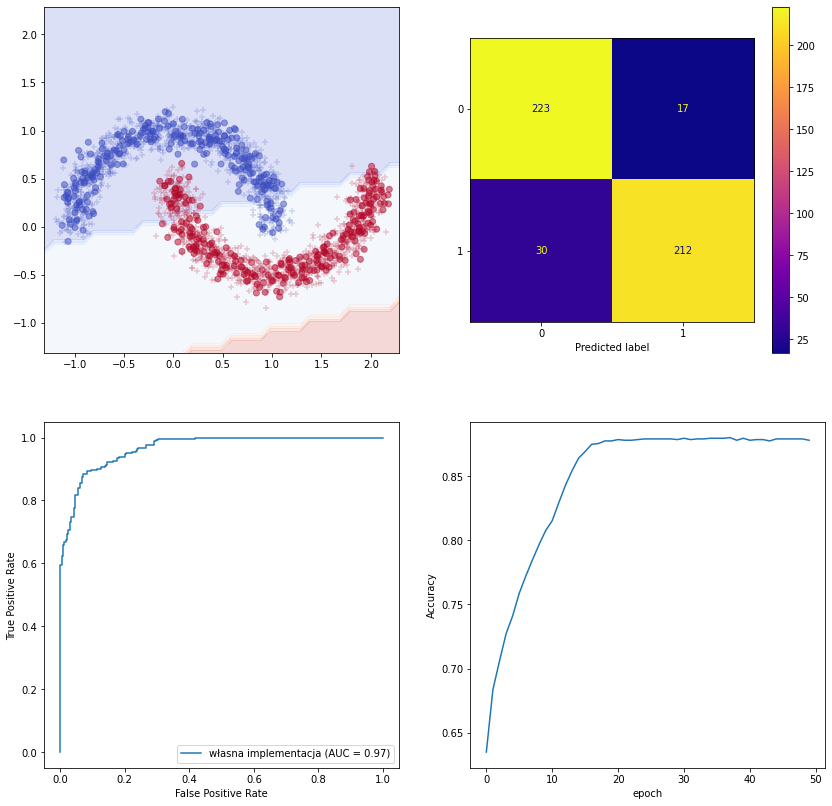

In [39]:
model = myNeuron(activationf='relu')
model.fit(X_train,y_train,epochs = 50)
vis(model, "relu")

irelu
Czułość       |   0.8884
Specyficzność |   0.9264
Skuteczność   |   0.9066
BACC          |   0.9074


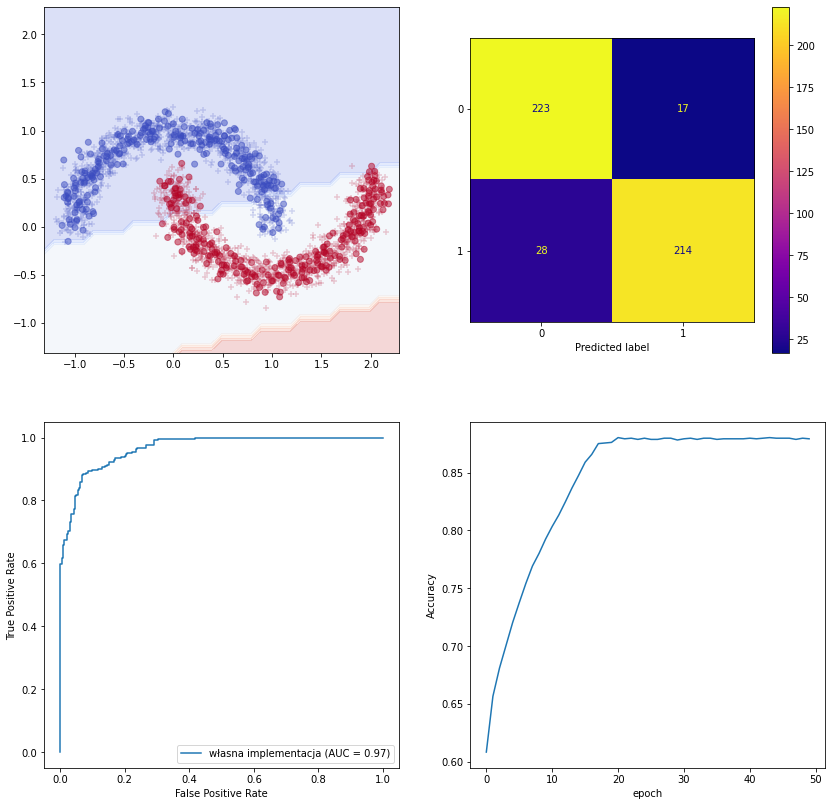

In [49]:
model = myNeuron(activationf='irelu')
model.fit(X_train,y_train,epochs = 50)
vis(model, "irelu")